# Pronóstico adaptativo

## Descripción del problema real

Los pronósticos de los precios de la electricidad en mercados liberalizados son un insumo fundamental para la toma de decisiones dentro de las organizaciones. Fundamentalmente, los pronosticos de corto plazo son utilizados en decisiones de carácter operativo. En el caso abordado, es necesario contar con los pronósticos para definir la politica de operación de una empresa del sector eléctrico.

## Descripción del problema en términos de los datos

La carpeta `datos/precios/` contiene los precios historicos horarios de la electricidad en la Bolsa de Energía del mercado eléctrico colombiano, publicados por el operador del mercado. Se desean obtener pronósticos para el precio promedio diario para los próximos siete (7) días a la fecha actual.

## Aproximaciones posibles

En este caso, se desea evaluar la capacidad de pronóstico de un ADALINE con aprendizaje en línea.

## Requerimientos

Usted debe:

* Procesar los datos históricos para conformar el conjunto de datos. Los archivos de Excel no pueden ser modificados y actualizados directamente por el operador del sistema. Su código debe leer los archivos y crear la serie de precios promedio diarios de la electricidad.


* Determinar si el modelo debe pronosticar los precios promedios sin ninguna transformación, o si la inclusión de una transformación (logaritmo natural, raíz cúbica, raíz cuadrada, etc) resulta en un incremento de la precisión del pronóstico.


* Generar el pronóstico para los precios de los próximos siete días.


* Preparar el código para que el modelo sea entrenado usando el gradiente y el momentum.


* Determinar cuál es el número óptimo de retardos (observaciones) que el modelo debe considerar hacia atrás para producir el pronóstico.


* Determinar los valores óptimos de la tasa de aprendizaje y el momentum.


In [2]:
import pandas as pd
import glob
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
%matplotlib inline
########CUIDADO###########
metricas = pd.DataFrame()
np.random.seed(0)

In [3]:
filenames = glob.glob('datos\precios\*.xlsx')
filenamesx = glob.glob('datos\precios\*.xls')
filenames = filenames + filenamesx

data = pd.DataFrame()
ano=1995
for f in filenames:
    if ano<2000:
        aux = pd.read_excel(f,header=3)
    
    elif ano==2000 or ano==2005 or ano>=2010 :
        aux = pd.read_excel(f,header=2)
        aux = aux.drop(['Version'],axis=1)
        
    else:
        aux = pd.read_excel(f,header=2)
        
    ano+=1  
    data = data.append(aux,sort=False)
    #data = pd.concat([data,aux])
del ano, aux, f, filenames, filenamesx
data = data.dropna(subset=['Fecha'])
data = data[data.columns[:-2]] 
data = data.fillna(0)
data['promedio'] = data.mean(axis=1)
data = data.reset_index(drop=True)
data = data[['Fecha','promedio']]
data['Fecha'] = data['Fecha'].astype('datetime64[D]')
data['anho'] = data['Fecha'].dt.strftime('%Y')
data['anho'] = data['anho'].astype('int')
data['mes'] = data['Fecha'].dt.strftime('%m')
data['mes'] = data['mes'].astype('int')
data['dia'] = data['Fecha'].dt.strftime('%d')
data['dia'] = data['dia'].astype('int')

data.head(5)

,Fecha,promedio,anho,mes,dia
0,1995-07-20,1.350708,1995,7,20
1,1995-07-21,4.924333,1995,7,21
2,1995-07-22,1.269500,1995,7,22
3,1995-07-23,0.953083,1995,7,23
4,1995-07-24,4.305917,1995,7,24


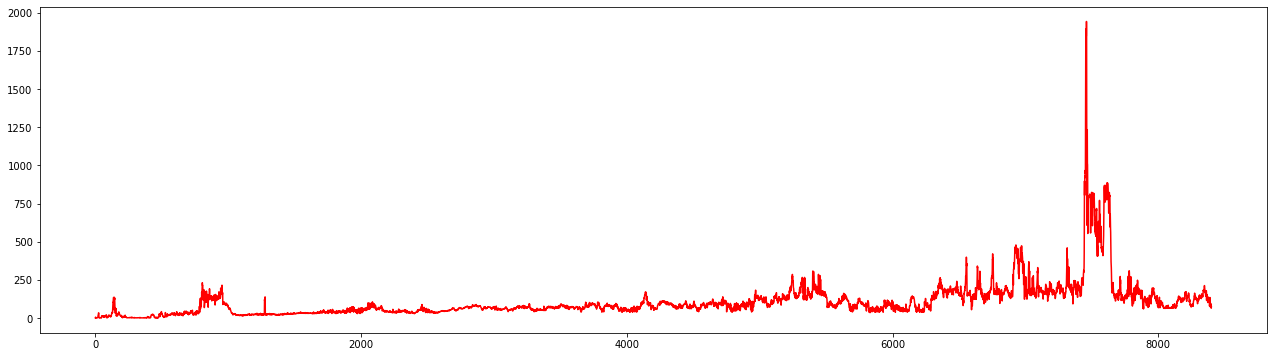

In [4]:
plt.figure(figsize=(22,6))
plt.plot(data['promedio'].values, color='red');

In [5]:
ipc = pd.read_excel('datos/1.2.5.IPC_Serie_variaciones.xlsx',header =12)
ipc = ipc.iloc[:-6] 
ipc = ipc.iloc[:,0:2] 
ipc.columns = ['Corte', 'indice']
ipc.head(10)

,Corte,indice
0,202002,104.94
1,202001,104.24
2,201912,103.80
3,201911,103.54
4,201910,103.43
5,201909,103.26
6,201908,103.03
7,201907,102.94
8,201906,102.71
9,201905,102.44


In [6]:
ipc['Corte'] = ipc['Corte'].astype(str)
ipc['Corte'] = ipc['Corte'].apply(lambda x: x[:4] + '-' + x[4:])
ipc['Corte'] = pd.to_datetime(ipc['Corte']).dt.to_period('M')
data['Corte'] = pd.to_datetime(data['Fecha']).dt.to_period('M')
ipc.head(10)                                

,Corte,indice
0,2020-02,104.94
1,2020-01,104.24
2,2019-12,103.80
3,2019-11,103.54
4,2019-10,103.43
5,2019-09,103.26
6,2019-08,103.03
7,2019-07,102.94
8,2019-06,102.71
9,2019-05,102.44


In [7]:
indiceBase = ipc.tail(1).iloc[0,1]
#indiceBase = ipc['indice']
indiceBase

0.03

In [8]:
data = pd.merge(data, ipc[["Corte", "indice"]], on="Corte", how="left")
data['promedioIPC'] =  data['promedio'] * indiceBase / data['indice']
data.head(5)

,Fecha,promedio,anho,mes,dia,Corte,indice,promedioIPC
0,1995-07-20,1.350708,1995,7,20,1995-07,20.93,0.001936
1,1995-07-21,4.924333,1995,7,21,1995-07,20.93,0.007058
2,1995-07-22,1.269500,1995,7,22,1995-07,20.93,0.001820
3,1995-07-23,0.953083,1995,7,23,1995-07,20.93,0.001366
4,1995-07-24,4.305917,1995,7,24,1995-07,20.93,0.006172


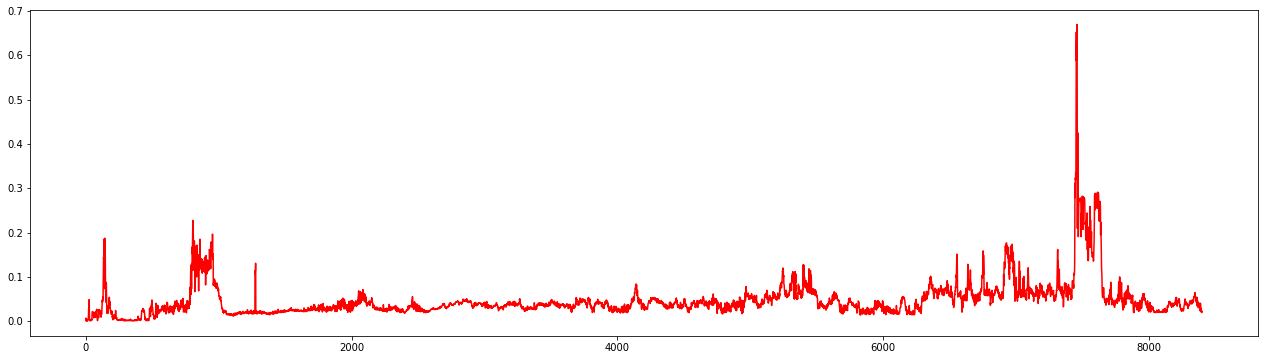

In [9]:
plt.figure(figsize=(22,6))
plt.plot(data['promedioIPC'].values, color='red');

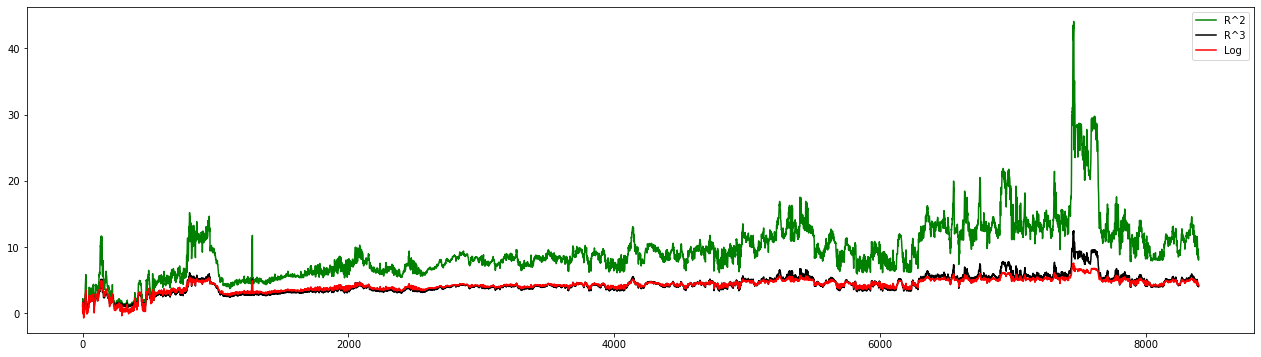

In [10]:
dataTrans = data['promedio'].copy()
dataR2 = np.sqrt(dataTrans)
dataR3 = np.power(dataTrans,(1/3))
dataLog = np.log(dataTrans)

plt.figure(figsize=(22,6))
plt.plot(dataR2, color='green',label='R^2')
plt.plot(dataR3, color='black',label='R^3')
plt.plot(dataLog, color='red',label='Log')
plt.legend()
plt.show()

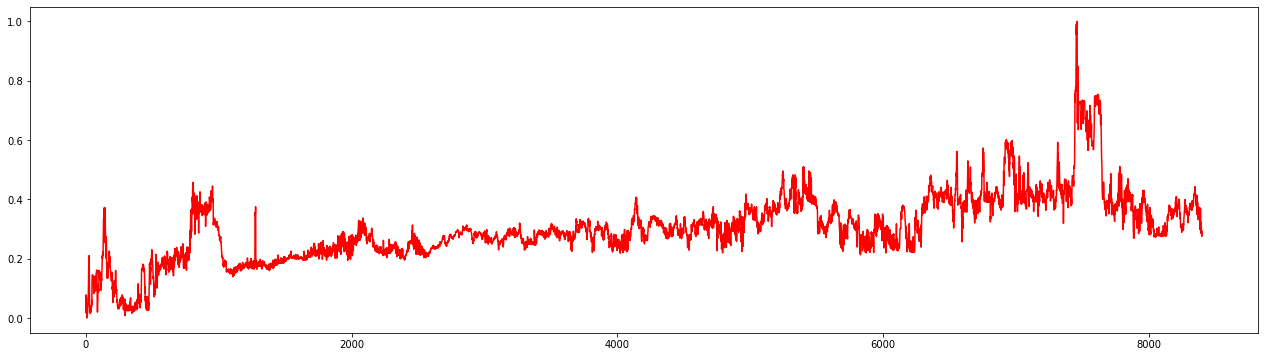

In [11]:
normalizador = MinMaxScaler().fit(np.array(dataR3).reshape(-1,1))
R3 = normalizador.transform(np.array(dataR3).reshape(-1,1))
plt.figure(figsize=(22,6))
plt.plot(R3, color = 'red')

In [12]:
class Adaline:
    def __init__(self,
                 learning_rate=0.001, # tasa de aprendizaje
                 max_epochs=100,      # número máximo de iteraciones sobre el set de datos
                 shuffle=False,       # mezcla patrones para aprendizaje online
                 random_state=None,   #
                 warm_start=False):   #

        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.shuffle = shuffle
        self.random_state = random_state
        self.warm_start = warm_start
        self.coef_ = None
        self.intercept_ = None

    def fit(self, X, y):

        if not isinstance(X, np.ndarray):
            X = np.array(X)
        if not isinstance(y, np.ndarray):
            d = np.array(y)
        else:
            d = y.copy()

        if self.random_state is not None:
            np.random.RandomState(self.random_state)

        if self.coef_ is None or self.warm_start is False:
            self.coef_ = np.random.uniform(-1, 1, X.shape[1])

        if self.intercept_ is None  or self.warm_start is False:
            self.intercept_ = np.random.uniform(-1, 1, 1)

        errors2 = []
        forecasts = []

        for epoch in range(self.max_epochs):

            if self.shuffle is True:
                n = list(range(X.shape[0]))
                np.random.shuffle(n)
                X = X[n,:]
                d = d[n]

            for i in range(X.shape[0]):
                u = np.dot(X[i,:], self.coef_) + self.intercept_
                e = (d[i] - u)[0]
                self.coef_ += 2 * self.learning_rate * e * X[i,:]
                self.intercept_ += 2 * self.learning_rate * e
                errors2.append(e**2)
                forecasts.append(u)

        return errors2, forecasts

    def predict(self, X):
        if not isinstance(X, np.ndarray):
            X = np.array(X)
        u = np.dot(X, self.coef_) + self.intercept_
        return u

In [13]:
d = list(R3.reshape(1,-1)[0])

In [14]:
L = 8

for lRate in (0.001,0.005,0.01,0.05,0.1):
    for epochs in (1,10,100):        

        ##
        ## Forma la matriz X
        ##
        X = []
        for t in range(L, len(d)):
            X.append(d[t-L:t].copy())
            model = Adaline(
            learning_rate=lRate,  # tasa de aprendizaje
            max_epochs=epochs,        # número máximo de iteraciones sobre el set de datos
            shuffle=False,       # mezcla patrones para aprendizaje online
            random_state=123,   #corrida reproducible
            warm_start=False)    #inicia con pesos aleatorios
            
        errors2, forecasts = model.fit(X,d[L:])


    
        #forecasts = normalizador.inverse_transform(np.array(dataR3).reshape(-1,1))    
    
        lonTest = 7
        test = d[len(d)-lonTest:len(d)]
        predict = forecasts[len(forecasts) - lonTest:len(forecasts)]

        
        
        mse = mean_squared_error(test, predict)
        mae = mean_absolute_error(test, predict)
        aux = pd.DataFrame({'learningrate': [lRate], 'maxepochs': [epochs], 'mse': [mse], 'mae': [mae], 'predict' : [predict], 'test' : [test]})
        metricas = metricas.append(aux)
        
        

In [16]:
metricas

,learningrate,maxepochs,mse,mae,predict,test
0,0.001,1,0.001468,0.032191,"[[0.3162086573917694], [0.3210501961010406], [...","[0.28580166799481854, 0.3221729409331285, 0.28..."
0,0.001,10,0.007500,0.081568,"[[0.37507164667801157], [0.42066331280656494],...","[0.28580166799481854, 0.3221729409331285, 0.28..."
0,0.001,100,0.001038,0.023489,"[[0.33154108150919825], [0.32326926235168096],...","[0.28580166799481854, 0.3221729409331285, 0.28..."
0,0.005,1,0.006903,0.077069,"[[0.33173313382431496], [0.35173040113579085],...","[0.28580166799481854, 0.3221729409331285, 0.28..."
0,0.005,10,0.002120,0.042458,"[[0.35907216114042184], [0.3661004748373786], ...","[0.28580166799481854, 0.3221729409331285, 0.28..."
0,0.005,100,0.000564,0.020200,"[[0.319446220335606], [0.2933487482752661], [0...","[0.28580166799481854, 0.3221729409331285, 0.28..."
0,0.010,1,0.011349,0.104430,"[[0.4329218513339348], [0.42444284408934474], ...","[0.28580166799481854, 0.3221729409331285, 0.28..."
0,0.010,10,0.001308,0.031714,"[[0.3431464369283333], [0.3115581387678652], [...","[0.28580166799481854, 0.3221729409331285, 0.28..."
0,0.010,100,0.000565,0.020477,"[[0.32361654270235635], [0.30258610312011514],...","[0.28580166799481854, 0.3221729409331285, 0.28..."
0,0.050,1,0.001795,0.032772,"[[0.37490174914247987], [0.3232471061420928], ...","[0.28580166799481854, 0.3221729409331285, 0.28..."


In [18]:
print(metricas.mse.min())
print(metricas.mae.min())

0.0004233278997501018
0.016864353165052397


In [20]:
best_model = metricas.loc[(metricas.mse == metricas.mse.min()) & (metricas.mae == metricas.mae.min())]
best_model

,learningrate,maxepochs,mse,mae,predict,test
0,0.05,10,0.000423,0.016864,"[[0.3277770489727518], [0.3139027097820042], [...","[0.28580166799481854, 0.3221729409331285, 0.28..."


In [33]:
predict = best_model['predict']
predict = predict.reshape(1,-1)
predict

AttributeError: 'Series' object has no attribute 'reshape'

In [41]:
predict = best_model['predict'].values
#prdict = normalizador.inverse_transform(np.array(predict).reshape(-1,1))
predict

array([list([array([0.32777705]), array([0.31390271]), array([0.31147872]), array([0.30966468]), array([0.29191856]), array([0.2917951]), array([0.29949687])])],
      dtype=object)

ValueError: setting an array element with a sequence.

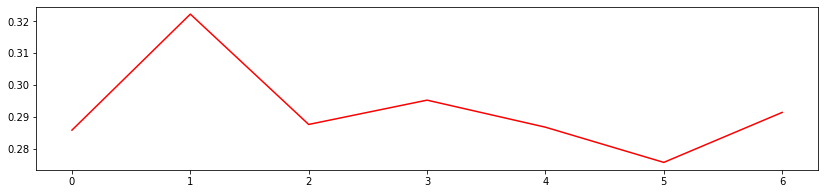

In [27]:
plt.figure(figsize=(14,3))
plt.plot(test, color='red');
plt.plot(predict, color = 'blue');

In [197]:
##  Primero debemos preparar los datos
##  Para pronosticar el valor actual se toman los `L`
##  valores previos de la serie
##

L = 8
lRate = 0.005
epochs = 1000


d = list(R3.reshape(1,-1)[0])

##
## Forma la matriz X
##
X = []
for t in range(L, len(d)):
    X.append(d[t-L:t].copy())

In [198]:
# Creamos el modelo
model = Adaline(
    learning_rate=lRate,  # tasa de aprendizaje
    max_epochs=epochs,        # número máximo de iteraciones sobre el set de datos
    shuffle=False,       # mezcla patrones para aprendizaje online
    random_state=123,   #corrida reproducible
    warm_start=False)    #inicia con pesos aleatorios

In [268]:
#Entrenamiento del modelo
errors2, forecasts = model.fit(
    X,
    d[L:])
# Ahora dividimos la data 
lonTest = 7
test = d[len(d)-lonTest:len(d)]
predict = forecasts[len(forecasts) - lonTest:len(forecasts)]


In [269]:
mse = mean_squared_error(test, predict)
mae = mean_absolute_error(test, predict)

print('mse:',mse)
print('mae:',mae)

plt.figure(figsize=(14,3))
plt.plot(test, color='red');
plt.plot(predict, color = 'blue');



ValueError: Found input variables with inconsistent numbers of samples: [7, 0]

In [201]:
#datos = {'L': L ,'learningrate': lRate,'maxepochs': epochs,'mse': mse,'mae': mae}
aux = pd.DataFrame({'learningrate': [lRate], 'maxepochs': [epochs], 'mse': [mse], 'mae': [mae]})
metricas = metricas.append(aux)
metricas

,L,learningrate,maxepochs,mse,mae
0,8,0.0500,1,0.000347,0.016543
0,8,0.0500,10,0.000591,0.020063
0,8,0.0500,100,0.000535,0.018741
0,8,0.0500,1000,0.000535,0.018738
0,8,0.0050,1,0.002590,0.047423
0,8,0.0050,10,0.001992,0.041526
0,8,0.0050,100,0.000568,0.021186
0,8,0.0050,1000,0.000520,0.018920
0,9,0.0050,1,0.006248,0.066194
0,9,0.0050,10,0.000378,0.014614


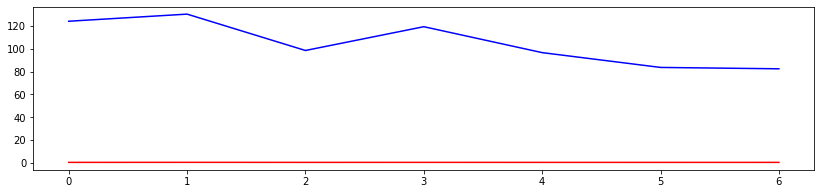

In [246]:
L = 8

d = list(R3.reshape(1,-1)[0])

##
## Forma la matriz X
##
X = []
P = []
for t in range(L, len(d)):
    X.append(d[t-L:t].copy())
    
model = Adaline(
    learning_rate=0.005,  # tasa de aprendizaje
    max_epochs=10,        # número máximo de iteraciones sobre el set de datos
    shuffle=False,       # mezcla patrones para aprendizaje online
    random_state=123,   #corrida reproducible
    warm_start=False)    #inicia con pesos aleatorios
#Entrenamiento del modelo
errors2, forecasts = model.fit(X,d[L:])
# Ahora predecimos 
#for i in range(7):
#    u = adaline.predict(X[-1]) 
#    next_X = np.append(X[-1][1:L], [u]) 
#    X = np.concatenate( ( X, [next_X] ), axis=0)
#    forecasts.append(u[0]) 
#    P.append(u[0])

    
#forecasts = normalizador.inverse_transform(np.array(dataR3).reshape(-1,1))    
    
lonTest = 7
test = d[len(d)-lonTest:len(d)]
predict = forecasts[len(forecasts) - lonTest:len(forecasts)]

predict = normalizador.inverse_transform(predict)
predict = np.power(predict,3)


#mse = mean_squared_error(test, predict)
#mae = mean_absolute_error(test, predict)

#print('mse:',mse)
#print('mae:',mae)

plt.figure(figsize=(14,3))
plt.plot(test, color='red');
plt.plot(predict, color = 'blue');